# {func}`torch.onnx.export` 导出到 ONNX

参考：[将模型从 PyTorch 导出到 ONNX 并使用 ONNX Runtime 运行](https://pytorch.org/tutorials//advanced/super_resolution_with_onnxruntime.html?highlight=onnx)
 
在这个教程中，我们描述了如何使用 TorchScript 的 `torch.onnx.export` ONNX 导出器将 PyTorch 中定义的模型转换为 ONNX 格式。

导出的模型将使用ONNX Runtime执行。ONNX Runtime是一个专注于性能的ONNX模型引擎，它可以在多个平台和硬件上（包括Windows、Linux和Mac，以及CPU和GPU）高效地进行推理。如这里所解释的，ONNX Runtime已经在多个模型上证明了可以显著提升性能。

In [1]:
# Some standard imports
import numpy as np

from torch import nn
import torch.utils.model_zoo as model_zoo
import torch.onnx

超分辨率是一种提高图像和视频分辨率的方法，广泛用于图像处理或视频编辑中。在这个教程中，我们将使用小的超分辨率模型。

首先，让我们在 PyTorch 中创建 `SuperResolution` 模型。这个模型使用了“[实时单图像和视频超分辨率：一种有效的子像素卷积神经网络](https://arxiv.org/abs/1609.05158)”一文（Shi等人）中描述的高效子像素卷积层来提高图像的分辨率。该模型接受图像的 YCbCr 的 `Y` 分量作为输入，并输出超分辨率下的上采样 `Y` 分量。

[模型](https://github.com/pytorch/examples/blob/master/super_resolution/model.py)直接来自 PyTorch 的例子，未经修改。

In [2]:
# Super Resolution model definition in PyTorch
import torch.nn as nn
import torch.nn.init as init


class SuperResolutionNet(nn.Module):
    def __init__(self, upscale_factor, inplace=False):
        super(SuperResolutionNet, self).__init__()

        self.relu = nn.ReLU(inplace=inplace)
        self.conv1 = nn.Conv2d(1, 64, (5, 5), (1, 1), (2, 2))
        self.conv2 = nn.Conv2d(64, 64, (3, 3), (1, 1), (1, 1))
        self.conv3 = nn.Conv2d(64, 32, (3, 3), (1, 1), (1, 1))
        self.conv4 = nn.Conv2d(32, upscale_factor ** 2, (3, 3), (1, 1), (1, 1))
        self.pixel_shuffle = nn.PixelShuffle(upscale_factor)

        self._initialize_weights()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.pixel_shuffle(self.conv4(x))
        return x

    def _initialize_weights(self):
        init.orthogonal_(self.conv1.weight, init.calculate_gain('relu'))
        init.orthogonal_(self.conv2.weight, init.calculate_gain('relu'))
        init.orthogonal_(self.conv3.weight, init.calculate_gain('relu'))
        init.orthogonal_(self.conv4.weight)

# Create the super-resolution model by using the above model definition.
torch_model = SuperResolutionNet(upscale_factor=3)

通常，你现在会训练这个模型；然而，在这个教程中，我们将改为下载一些预训练的权重。请注意，这个模型并没有完全训练以获得良好的准确性，这里仅用于演示目的。

在导出模型之前，调用 `torch_model.eval()` 或 `torch_model.train(False)` 将模型切换到推理模式是重要的。这是必需的，因为像 `dropout` 或 `batchnorm` 这样的算子在推理和训练模式下的行为是不同的。

In [3]:
# Load pretrained model weights
model_url = 'https://s3.amazonaws.com/pytorch/test_data/export/superres_epoch100-44c6958e.pth'
batch_size = 1    # just a random number

# Initialize model with the pretrained weights
map_location = lambda storage, loc: storage
if torch.cuda.is_available():
    map_location = None
torch_model.load_state_dict(model_zoo.load_url(model_url, map_location=map_location))

# set the model to inference mode
torch_model.eval()

SuperResolutionNet(
  (relu): ReLU()
  (conv1): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(32, 9, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pixel_shuffle): PixelShuffle(upscale_factor=3)
)

在 PyTorch 中导出模型是通过追踪或脚本化（tracing or scripting）来实现的。这个教程将以通过追踪导出的模型为例。要导出模型，我们调用 {func}`torch.onnx.export` 函数。这将执行模型，记录用于计算输出的算子的轨迹。由于导出需要运行模型，我们需要提供输入张量 `x`。只要类型和大小正确，这个张量的值可以是随机的。请注意，除非指定为动态轴，否则导出的 ONNX 图中所有输入维度的大小都将是固定的。在这个例子中，我们导出了批量大小为 `1` 的输入模型，然后在 `torch.onnx.export()` 的 `dynamic_axes` 参数中将第一个维度指定为动态。因此，导出的模型将接受大小为 `[batch_size, 1, 224, 224]` 的输入，其中 `batch_size` 可以是可变的。

要了解更多关于 PyTorch 导出接口的细节，请查阅 [`torch.onnx` 文档](https://pytorch.org/docs/master/onnx.html)。

In [4]:
# Input to the model
x = torch.randn(batch_size, 1, 224, 224, requires_grad=True)
torch_out = torch_model(x)
# 导出模型
torch.onnx.export(torch_model,               # torch 模型
                  x,                         # 模型输入或者对于多个输入，使用元组
                  "super_resolution.onnx",               # 模型保存的位置（可以是文件或类似文件的对象）
                  export_params=True,        # 将训练后的参数权重存储在模型文件内
                  opset_version=18,          # 导出模型的 ONNX 版本
                  do_constant_folding=True,  # 是否执行常量折叠以进行优化
                  input_names = ['data'],   # 模型的输入名称
                  output_names = ['output'], # 模型的输出名称
                  dynamic_axes={'data' : {0 : 'batch_size'},    # 可变长度的轴
                                'output' : {0 : 'batch_size'}})

/media/pc/data/tmp/cache/conda/envs/xin/lib/python3.12/site-packages/torch/onnx/utils.py:1548: OnnxExporterWarning: Exporting to ONNX opset version 18 is not supported. by 'torch.onnx.export()'. The highest opset version supported is 17. To use a newer opset version, consider 'torch.onnx.dynamo_export()'. Note that dynamo_export() is in preview. Please report errors with dynamo_export() as Github issues to https://github.com/pytorch/pytorch/issues.
  warnings.warn(


我们也计算了 `torch_out`，即模型的输出，我们将使用它来验证导出的模型在 ONNX Runtime 中运行时是否计算出相同的值。

但在用 ONNX Runtime 验证模型的输出之前，我们将使用 ONNX API 检查 ONNX 模型。首先，`onnx.load("super_resolution.onnx")` 将加载保存的模型，并输出 `onnx.ModelProto` 结构（一种用于打包机器学习模型的顶级文件/容器格式。有关更多信息，请参阅 [onnx.proto 文档](https://github.com/onnx/onnx/blob/master/onnx/onnx.proto)）。然后，`onnx.checker.check_model(onnx_model)` 将验证模型的结构，并确认模型具有有效的模式。通过检查模型的版本、图形的结构以及节点及其输入和输出，来验证 ONNX 图的有效性。

In [5]:
import onnx

onnx_model = onnx.load("super_resolution.onnx")
onnx.checker.check_model(onnx_model)

现在，让我们使用ONNX Runtime的Python APIs来计算输出。这部分通常可以在单独的进程或另一台机器上完成，但我们将在同一个进程中继续进行，以便我们可以验证ONNX Runtime和PyTorch是否为网络计算相同的值。

为了使用ONNX Runtime运行模型，我们需要为模型创建推理会话，并选择配置参数（这里我们使用默认配置）。一旦创建了会话，我们就使用 `run()` API来评估模型。这个调用的输出是一个包含由ONNX Runtime计算的模型输出的列表。

In [6]:
import onnxruntime

ort_session = onnxruntime.InferenceSession("super_resolution.onnx", providers=["CPUExecutionProvider"])

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

# compute ONNX Runtime output prediction
ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(x)}
ort_outs = ort_session.run(None, ort_inputs)

# compare ONNX Runtime and PyTorch results
np.testing.assert_allclose(to_numpy(torch_out), ort_outs[0], rtol=1e-03, atol=1e-05)

print("Exported model has been tested with ONNXRuntime, and the result looks good!")

Exported model has been tested with ONNXRuntime, and the result looks good!


我们应该看到PyTorch和ONNX Runtime运行的输出在给定精度（`rtol=1e-03`和`atol=1e-05`）下数值匹配。作为旁注，如果它们不匹配，则ONNX导出器存在问题，请在这种情况下联系我们。

使用ONNX Runtime在图像上运行模型
到目前为止，我们已经从PyTorch导出了一个模型，并展示了如何加载它并在ONNX Runtime中用一个虚拟张量作为输入来运行它。

对于这个教程，我们将使用一张广泛使用的著名猫的图片。

首先，让我们加载图片，并使用标准的 `PIL`（Python Imaging Library）库对其进行预处理。请注意，这种预处理是为训练/测试神经网络处理数据的标准做法。

我们首先调整图像的大小以适应模型输入的大小（`224x224`）。然后，我们将图像分解为 `Y`、`Cb` 和 `Cr` 分量。这些分量分别代表灰度图像（`Y`），蓝色差（`Cb`）和红色差（`Cr`）色度分量。由于 `Y` 分量对人类视觉更敏感，我们对这一分量感兴趣，并将其转换。提取 `Y` 分量后，我们将其转换为张量，这将作为我们模型的输入。

In [7]:
from PIL import Image
import torchvision.transforms as transforms

img = Image.open("./images/cat_224x224.jpg")

resize = transforms.Resize([224, 224])
img = resize(img)

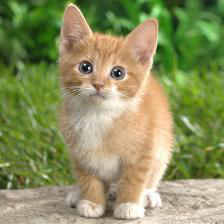

In [8]:
img

In [9]:
img_ycbcr = img.convert('YCbCr')
img_y, img_cb, img_cr = img_ycbcr.split()

to_tensor = transforms.ToTensor()
img_y = to_tensor(img_y)
img_y.unsqueeze_(0)

tensor([[[[0.2157, 0.1961, 0.1922,  ..., 0.5294, 0.5569, 0.5725],
          [0.2039, 0.1922, 0.1922,  ..., 0.5333, 0.5529, 0.5686],
          [0.2000, 0.1843, 0.1843,  ..., 0.5216, 0.5373, 0.5490],
          ...,
          [0.6667, 0.6745, 0.6392,  ..., 0.6902, 0.6667, 0.6078],
          [0.6392, 0.6431, 0.6235,  ..., 0.8000, 0.7608, 0.6745],
          [0.6392, 0.6353, 0.6510,  ..., 0.8118, 0.7686, 0.6667]]]])

现在，作为下一步，让我们取代表灰度缩放猫图像的张量，并像之前解释的那样在ONNX Runtime中运行超分辨率模型。

In [10]:
ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(img_y)}
ort_outs = ort_session.run(None, ort_inputs)
img_out_y = ort_outs[0]

此时，模型的输出是一个张量。现在，我们将处理模型的输出，从输出张量构建回最终的输出图像，并保存该图像。后处理步骤采用了[这里](https://github.com/pytorch/examples/blob/master/super_resolution/super_resolve.py)的PyTorch超分辨率模型实现。

In [11]:
img_out_y = Image.fromarray(np.uint8((img_out_y[0] * 255.0).clip(0, 255)[0]), mode='L')

# get the output image follow post-processing step from PyTorch implementation
final_img = Image.merge(
    "YCbCr", [
        img_out_y,
        img_cb.resize(img_out_y.size, Image.BICUBIC),
        img_cr.resize(img_out_y.size, Image.BICUBIC),
    ]).convert("RGB")

# Save the image, we will compare this with the output image from mobile device
final_img.save("./images/cat_superres_with_ort.jpg")

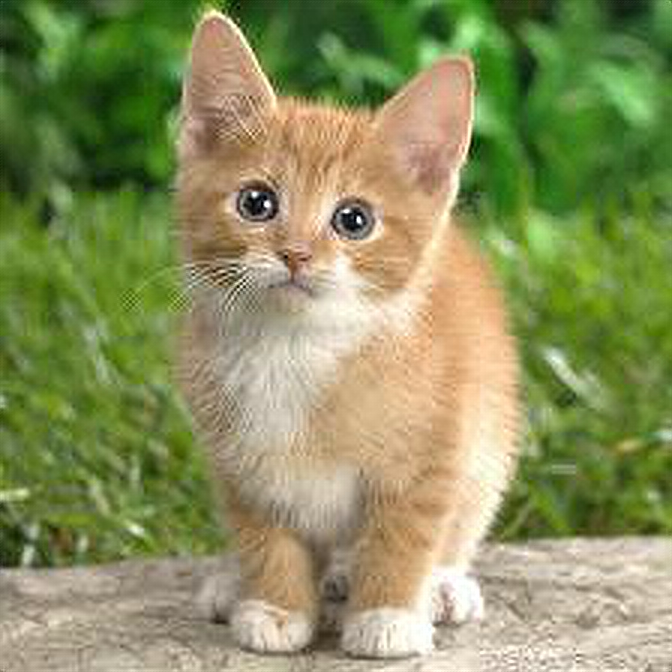

In [12]:
final_img